# VGG16

## Imports

In [16]:
# Import Library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
import tensorflow as tf
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Data Paths

In [17]:
#defining training and testing path for vgg16
train_path = '/kaggle/input/intel-image-classification-vgg16/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification-vgg16/seg_test/seg_test'


## Load Data

In [18]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)


## Number of Classes

In [19]:
# The number of classes of dataset
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


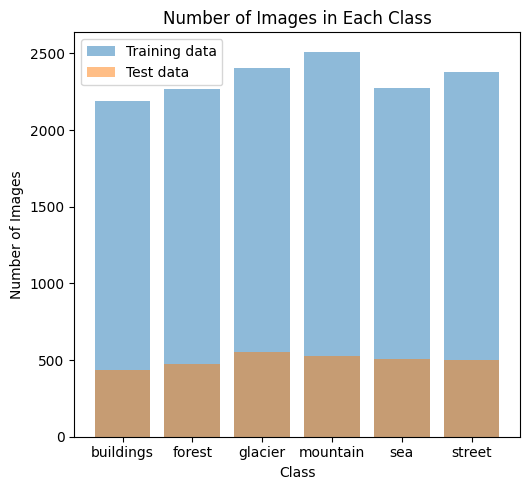

In [20]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

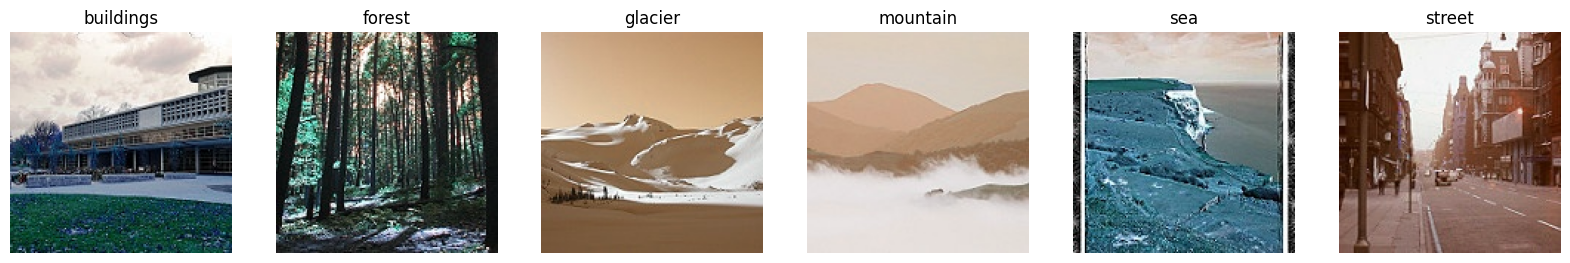

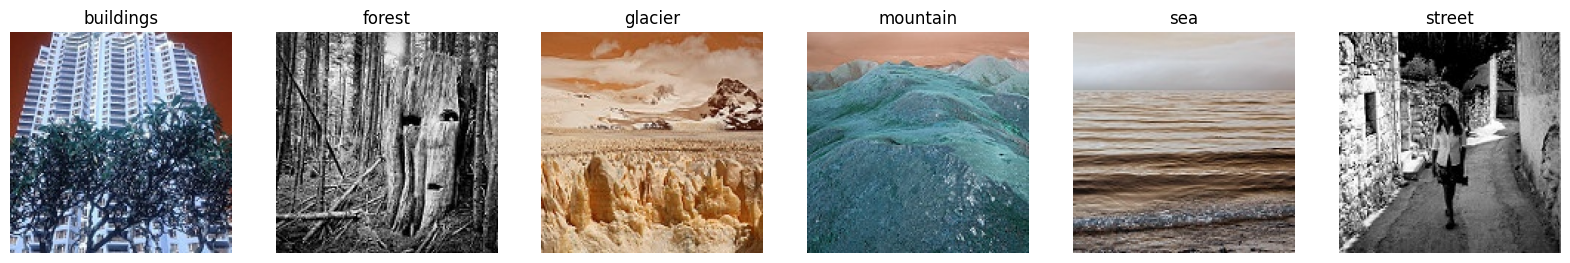

In [21]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [22]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [23]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(11227, 150, 150, 3)
(11227, 6)
(2807, 150, 150, 3)
(2807, 6)
(3000, 150, 150, 3)
(3000, 6)


## Normalize Data

In [24]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Model Architecture

In [12]:
from keras.applications.vgg16 import VGG16

IMAGE_SIZE = [150,150]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='/kaggle/input/vgg16/tensorflow2/vgg16/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(vgg.output)

prediction = tf.keras.layers.Dense(numberOfClass, activation='softmax')(x)


In [13]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        49,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,763,846 (56.32 MB)

 Trainable params: 49,158 (192.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/15


I0000 00:00:1718558899.153314     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718558899.173848     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6846 - loss: 0.8507

W0000 00:00:1718558960.610927     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718558963.720092     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718559019.586985     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6859 - loss: 0.8475 - val_accuracy: 0.8660 - val_loss: 0.3866
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - accuracy: 0.8912 - loss: 0.3228 - val_accuracy: 0.8735 - val_loss: 0.3612
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 343ms/step - accuracy: 0.9077 - loss: 0.2727 - val_accuracy: 0.8774 - val_loss: 0.3451
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 341ms/step - accuracy: 0.9229 - loss: 0.2294 - val_accuracy: 0.8828 - val_loss: 0.3319
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - accuracy: 0.9304 - loss: 0.2087 - val_accuracy: 0.8849 - val_loss: 0.3272
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.9428 - loss: 0.1847 - val_accuracy: 0.8782 - val_loss: 0.3487
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - accuracy: 0.9452 - loss: 0.1704 - val_accuracy: 0.8878 - val_loss: 0.3306
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - accuracy: 0.9557 - loss: 0.1522 - val_accuracy: 0.8846 

## Performance metrics 

### Accuracy and Loss

In [30]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

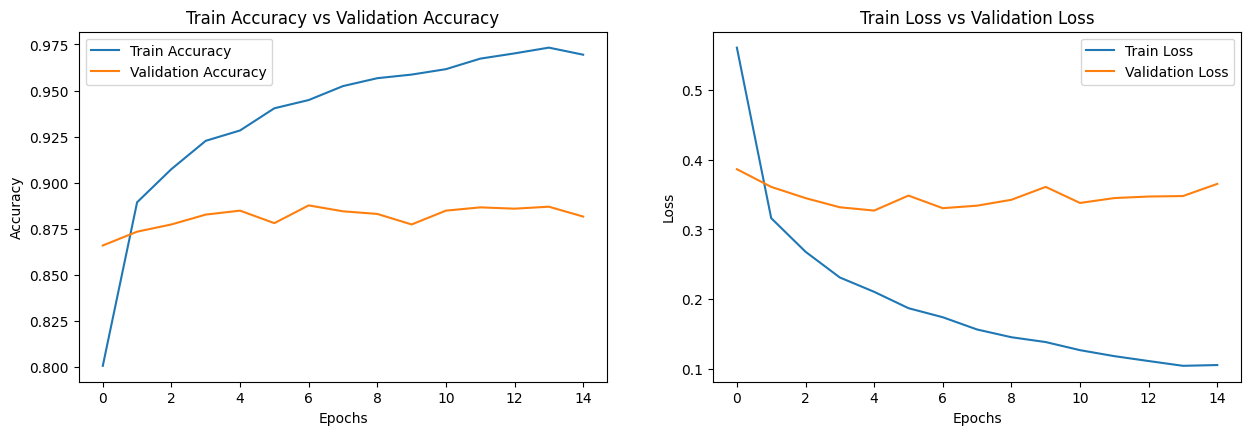

In [17]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix 

94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       437
           1       0.98      0.97      0.98       474
           2       0.89      0.74      0.81       553
           3       0.79      0.89      0.84       525
           4       0.88      0.94      0.91       510
           5       0.90      0.91      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



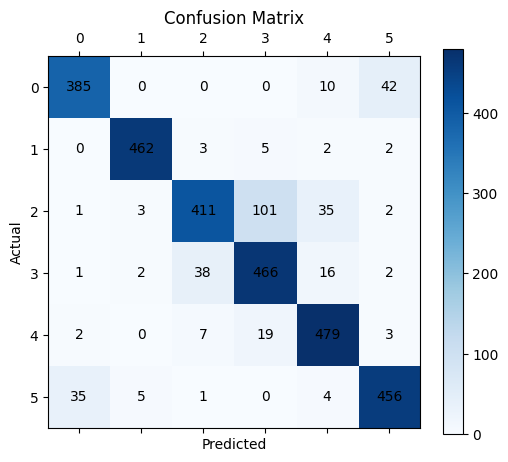

In [18]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [19]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.9745 - loss: 0.0922


W0000 00:00:1718559572.623991     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  97.48820066452026 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.8854 - loss: 0.3494
Accuracy of the model using validation data is -  88.17242383956909 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8812 - loss: 0.3410

Accuracy of the model is -  88.63333463668823 %


### Plot ROC Curves

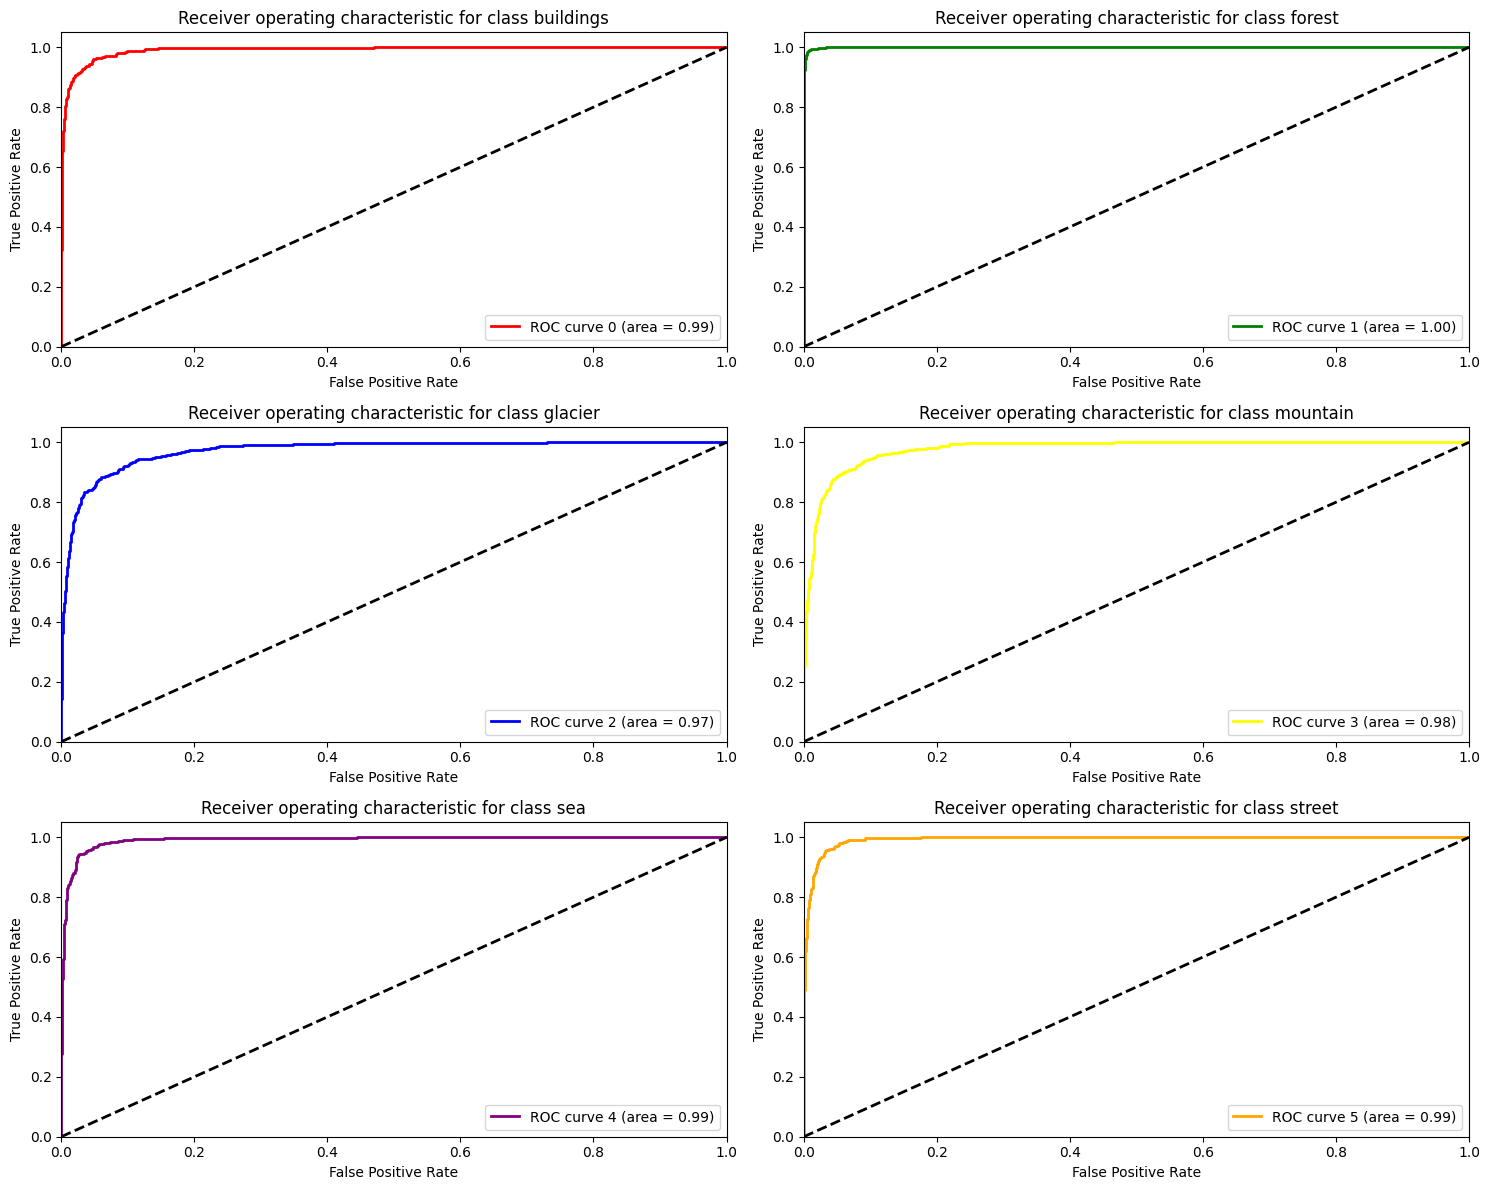

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve {class_index} (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# VGG16 with Fine Tunning

In [25]:
vgg2 = VGG16(input_shape = (150,150,3), weights='/kaggle/input/vgg16/tensorflow2/vgg16/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

In [26]:
model2 = Sequential()
model2.add(vgg2)
model2.add(layers.Flatten())
model2.add(layers.Dense(250, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax'))

vgg2.trainable = True

set_trainable = False
for layer in vgg2.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False



In [27]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [28]:
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(learning_rate=1e-5), metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
  1/176 ━━━━━━━━━━━━━━━━━━━━ 13:40 5s/step - accuracy: 0.1250 - loss: 2.4634

W0000 00:00:1718563826.461428    1812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4271 - loss: 1.4607

W0000 00:00:1718563853.935797    1813 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718563856.812103    1812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.4282 - loss: 1.4580 - val_accuracy: 0.8611 - val_loss: 0.4024
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - accuracy: 0.8450 - loss: 0.4243 - val_accuracy: 0.8874 - val_loss: 0.3370
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.8913 - loss: 0.3194 - val_accuracy: 0.8985 - val_loss: 0.3064
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9037 - loss: 0.2842 - val_accuracy: 0.9035 - val_loss: 0.2891
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9213 - loss: 0.2359 - val_accuracy: 0.9059 - val_loss: 0.2870
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9319 - loss: 0.1980 - val_accuracy: 0.9063 - val_loss: 0.2756
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9408 - loss: 0.1711 - val_accuracy: 0.9127 - val_loss: 0.2677
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9434 - loss: 0.1604 - val

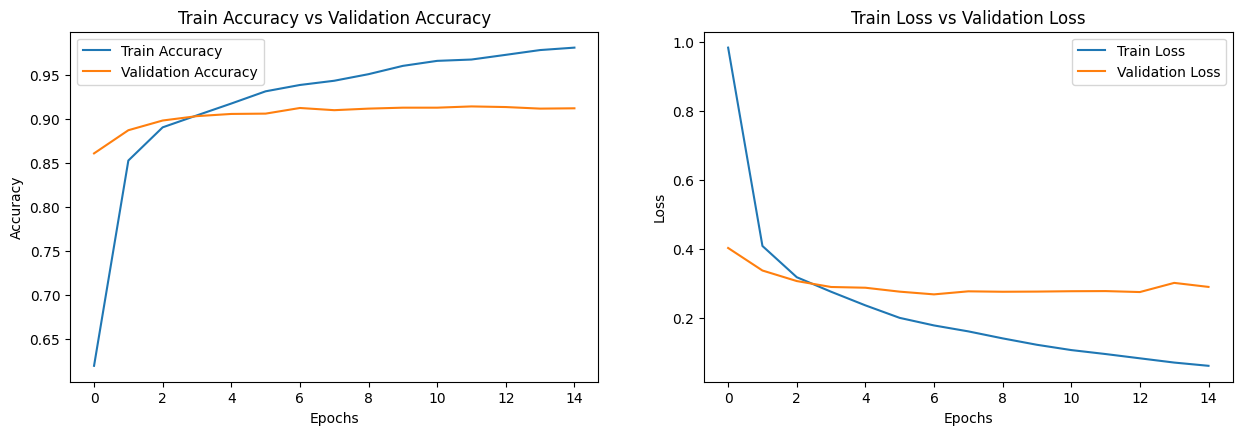

In [31]:
plot_accuracy_loss(history2)

 4/94 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step 

W0000 00:00:1718564383.862067    1813 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step


W0000 00:00:1718564404.811352    1812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.94      0.91      0.92       437
           1       0.98      0.98      0.98       474
           2       0.89      0.86      0.87       553
           3       0.88      0.86      0.87       525
           4       0.92      0.97      0.94       510
           5       0.92      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



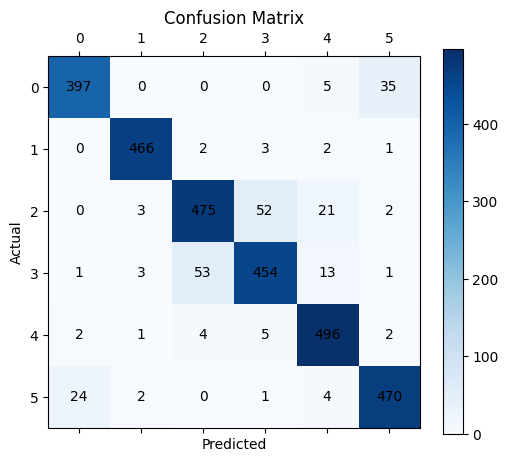

In [32]:
# Confusion Matrix
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
print("Accuracy of the model using training data is - ", model2.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model2.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model2.evaluate(X_test,y_test)[1]*100,"%")

  2/351 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 1.0000 - loss: 0.0186  

W0000 00:00:1718564421.562480    1811 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9944 - loss: 0.0318


W0000 00:00:1718564446.601066    1814 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  99.40322637557983 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9196 - loss: 0.2842


W0000 00:00:1718564468.580321    1812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using validation data is -  91.23619794845581 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9148 - loss: 0.2853

Accuracy of the model is -  91.93333387374878 %


W0000 00:00:1718564477.950609    1814 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Plot ROC Curves

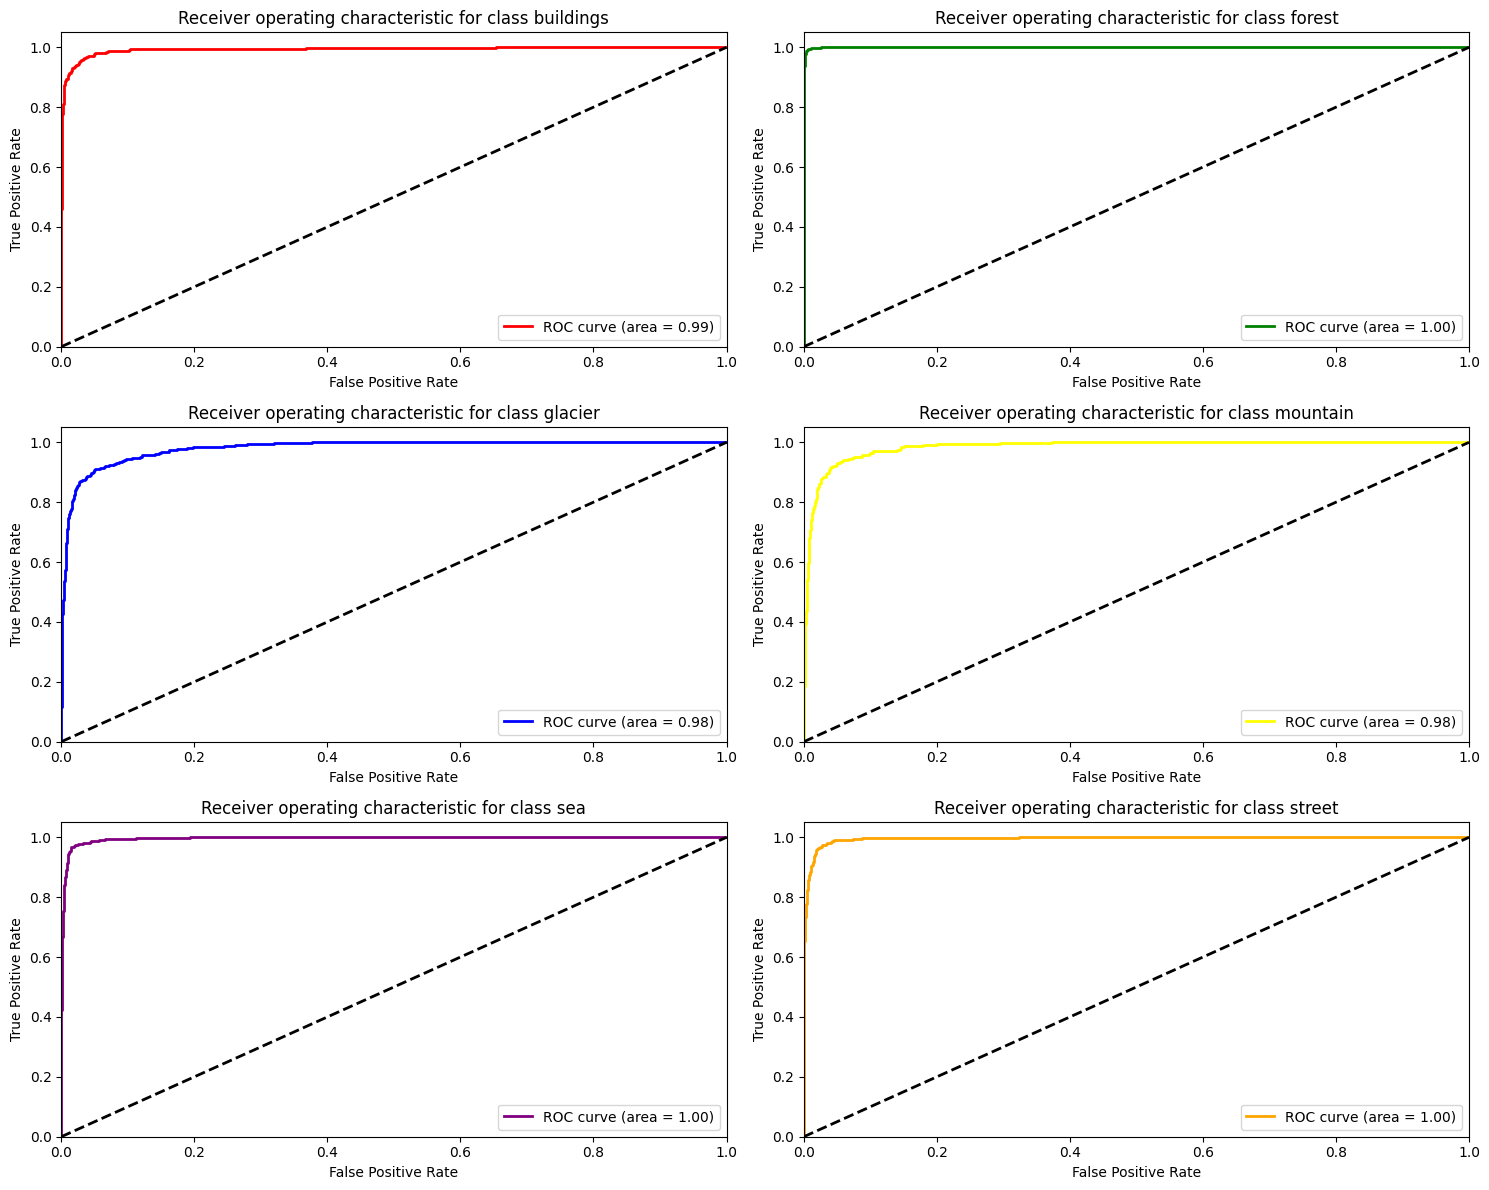

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()